In [2]:
                                                                                                                                                                                                                                                                                                                               %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.colors as colors
from _create_pdf import create_spins;
from _helper_functions import tsallis, cauchy, find_nearest_index;
from _steady_state import a_steady, a_steady_hp;
from _do_calculation import solve_mbes_floquet, solve_mbes
from _mbes import mbes_floquet, mbes, mbes_hp, mbes_floquet_hp
import _spin_params as spin_pars
from IPython.display import display, clear_output, Markdown, Javascript

In [3]:
gcoll = 2*np.pi*5
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr;
kappa = np.pi*fr/quali #HWHM
delta = spin_pars.delta #detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac #detuning drive to cavity wc-wp
gperp = 12#spin_pars.gperp #HWHM
gpar = spin_pars.gpar#0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = 3#spin_pars.nbins#701#5000#20
g_number = spin_pars.g_number #how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

2.484127032358824


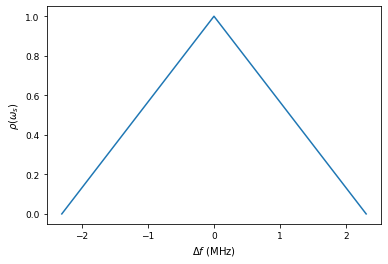

In [4]:
bool_holes = False
bool_inhomo = True
bool_hyperfine = False
spins, gs, pdf = create_spins(gcoll, q, delta, gammaq, nbins, holes=bool_holes, inhomo=bool_inhomo, hyperfine=bool_hyperfine)
spins = np.array([-2.3,0,2.3])
#pdf = np.array([1,1,1])
gs = gcoll/np.sqrt(3)
plt.figure()
plt.plot(spins, pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('$\\rho(\omega_s)$');
#spins = np.array([-10,5,15])
#pdf = np.array([1,1,1])
#gs = pdf*gcoll/np.sqrt(3)

Text(0, 0.5, 'amplitude')

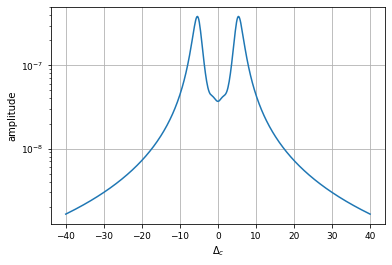

In [5]:
initsteady = (0.1,0.1)
fstart = 40
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 500)
etasteady = 0.01

losasteady = np.zeros(np.shape(deltaarr))


newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2

fig = plt.figure()
#the minus here switches the direction 
plt.semilogy(-deltaarr/2/np.pi, losasteady)
plt.grid(True)
plt.xlabel('$\Delta_c$')
plt.ylabel('amplitude')
#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [6]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    n = len(fcomps)
    pulse = 0
    for i in range(int(n/2)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)+fcomps[int(n/2)+i]*np.sin((i+1)*wgrund*t)
    return pulse

In [7]:
init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0

init_hp = np.zeros(len(spins)+1)

Text(0, 0.5, '$\\delta(t)$')

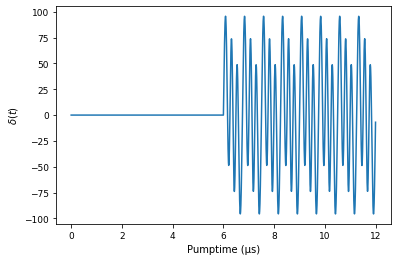

In [12]:
fcomps = np.array([  8.89642831,  15.65915532,  60.13314673, -38.17207363,   20.45650169,
  10.93505558,   5.47306439, 20])
#fcomps = [10, 10, -4]
tscale_pulse = 1
dt = 0.004

periods = 4
silent_periods = 2

tend = 3


wgrund = 2*np.pi/tend*periods
tp = np.arange(0, tend*periods, dt)
idx_period = find_nearest_index(tp, tend*(periods-1))
idx_silent = find_nearest_index(tp, tend*silent_periods)
delta_pulse = pulse_rwa(tp, (wgrund, fcomps))
delta_pulse[:idx_silent] = 0

pump, infodict = solve_mbes_floquet(mbes_floquet_hp, init_hp, pdf, tp, None, delta_pulse, tp, etasteady, kappa, deltac, gs, gperp, spins, gpar)
#pump_empty, infodict = solve_mbes(mbes, init, pdf, tp, None, etasteady, kappa, deltac, gs, gperp, spins, gpar)
pump_empty_hp, infodict = solve_mbes(mbes_hp, init_hp, pdf, tp, None, etasteady, kappa, deltac, gs, gperp, spins, gpar)

plt.plot(tp, delta_pulse)
plt.xlabel('Pumptime (µs)')
plt.ylabel('$\delta(t)$')

Value to beat:  3.659200082241157e-08
Current value:  4.310147203995363e-07


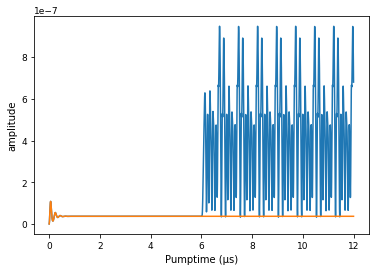

In [13]:
plt.plot(tp[:], abs(pump[:,0])**2)
plt.plot(tp[:], abs(pump_empty_hp[:, 0])**2)
plt.xlabel('Pumptime (µs)')
plt.ylabel('amplitude')
print("Value to beat: ", np.mean(abs(pump_empty_hp[idx_period:, 0]**2)))
print("Current value: ", np.mean(abs(pump[idx_period:, 0])**2))

In [ ]:
fcomps_init = np.array([-7.59300790e-03,  2.64831748e-02, -2.93791831e-02, -6.30935181e+01,0, 2])*0
n_fcomps = 16
random_fcomps = np.random.uniform(-40, 40, n_fcomps)*0

class MinimizeBasin():
    
    def __init__(self):
        self.minimize_res = 0.
        self.counter = 0
        self.disp1 = display(Markdown("### Minima Found: 0"), display_id='0')
        display(Markdown("#### Current Search"))
        self.minima_found = 0
        self.smallest = np.inf
        self.res_so_far = 0
        display(Markdown('Iter %s|      fcomps %s| f(X)'%("&nbsp;"*10, "&nbsp;"*10)))
        self.disp2 = display(Markdown(""), display_id='1')
        
    def minimize_func(self, X):
        delta_pulse = pulse_rwa(tp, (self.wgrund, X))
        delta_pulse[:idx_silent] = 0
        pump, infodict = solve_mbes_floquet(mbes_floquet_hp, init_hp, pdf, tp, None, delta_pulse, tp, etasteady, kappa, deltac, gs, gperp, spins, gpar)
        res = np.mean(abs(pump[idx_period:, 0])**2)
        self.minimize_res = res
        return res
    
    def callbackF(self, Xi):
        self.counter += 1
        s1 = ("%.4f, "*len(Xi))%tuple(Xi)
        string = ("%i%s|&nbsp;"+ s1[:-2]+"%s|&nbsp;%.10e")%(self.counter, "&nbsp;"*10, "&nbsp;"*10, self.minimize_res)
        self.disp2.update(Markdown(string))
        
    def callbackBasin(self, x, f, accept):
        self.counter = 0
        if f < self.smallest:
            self.smallest = f
        self.minima_found += 1
        self.res_so_far = x.copy()
        self.disp1.update(Markdown("### Minima Found: %d; Smallest so far: %.10e"%(self.minima_found, self.smallest)))
    
    def main(self, fcomps, temp, stepsize, wgrund):
        self.wgrund = wgrund
        res = scipy.optimize.basinhopping(self.minimize_func, x0=fcomps, T=temp, stepsize=stepsize, disp=True, callback=self.callbackBasin, minimizer_kwargs= {'callback':self.callbackF, 'method': 'Nelder-Mead'})
        return res
        
mini = MinimizeBasin()
res = mini.main(random_fcomps, 1, 18, wgrund)

### Minima Found: 8; Smallest so far: 3.6592000816e-08

#### Current Search

Iter &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|      fcomps &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| f(X)

378&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;5.9985, -8.9584, -6.4798, -600.6385, -20.6214, 2.3584, -5.6131, 23.9213, -6.0228, 8.5669, 5.4326, 600.4805, 20.8147, -4.6525, 5.8039, -22.8831&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;3.6989459767e-08

basinhopping step 0: f 3.6592e-08
basinhopping step 1: f 3.6592e-08 trial_f 3.6592e-08 accepted 1  lowest_f 3.6592e-08
found new global minimum on step 1 with function value 3.6592e-08
basinhopping step 2: f 3.6592e-08 trial_f 3.6592e-08 accepted 1  lowest_f 3.6592e-08
basinhopping step 3: f 3.6592e-08 trial_f 3.6592e-08 accepted 1  lowest_f 3.6592e-08
basinhopping step 4: f 3.6592e-08 trial_f 3.6592e-08 accepted 1  lowest_f 3.6592e-08
found new global minimum on step 4 with function value 3.6592e-08
basinhopping step 5: f 3.66335e-08 trial_f 3.66335e-08 accepted 1  lowest_f 3.6592e-08
basinhopping step 6: f 3.67284e-08 trial_f 3.67284e-08 accepted 1  lowest_f 3.6592e-08
basinhopping step 7: f 3.66071e-08 trial_f 3.66071e-08 accepted 1  lowest_f 3.6592e-08


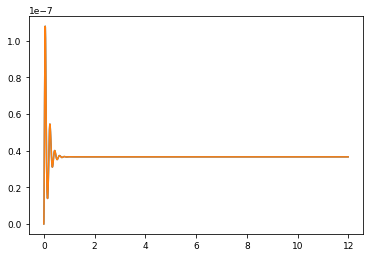

In [167]:
delta_pulse = pulse_rwa(tp, (wgrund, res.x))
delta_pulse[:idx_silent] = 0
pump, infodict = solve_mbes_floquet(mbes_floquet_hp, init_hp, pdf, tp, None, delta_pulse, tp, etasteady, kappa, deltac, gs, gperp, spins, gpar)
plt.plot(tp, abs(pump_empty_hp[:,0])**2)
plt.plot(tp, abs(pump[:, 0])**2)
#plt.ylim([3.75e-8, 3.8e-8])

### Checking how spectroscopy looks like

In [86]:
losasteady_floquet = np.zeros(np.shape(deltaarr))
newinit = initsteady
for i, delt in enumerate(deltaarr):
    print(i+1,"from", len(deltaarr) , end='\r')
    pump_spec, infodict = solve_mbes_floquet(mbes_floquet_hp, init_hp, pdf, tp, None, delta_pulse, tp, etasteady, kappa, delt, gs, gperp, spins, gpar)
    ar, ai = np.mean(pump_spec[idx_period:,0].real), np.mean(pump_spec[idx_period:,0].imag)
    losasteady_floquet[i] = ai**2+ar**2


KeyboardInterrupt: 

Text(0, 0.5, 'amplitude')

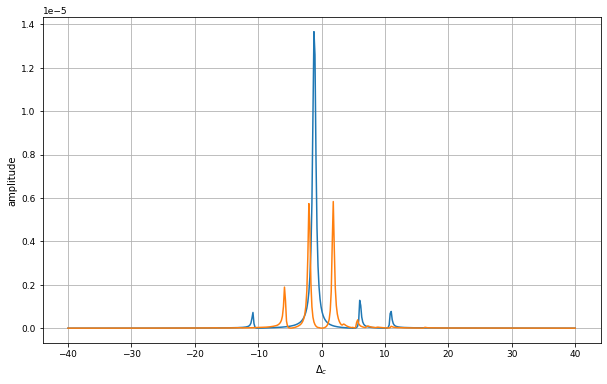

In [72]:
#print(res.x)
fig = plt.figure(figsize=(10,6))
plt.plot(-deltaarr/2/np.pi, losasteady)
plt.plot(-deltaarr/2/np.pi, losasteady_floquet)
plt.grid(True)
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.xlabel('$\Delta_c$')
plt.ylabel('amplitude')